Wrote by Yujing YANG

In [100]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

## Helper functions

In [101]:
# find the polII outliner: use slope = 1 line
def rlt_pos_to_line( version, p, a, b ):
    isabove = lambda p, a,b: np.cross(p-a, b-a) < 0
    isbelow = lambda p, a,b: np.cross(p-a, b-a) > 0
    if version == "above":
        return isabove(p,a,b) * 1
    elif version == "below":
        return isbelow(p,a,b) * 1
    
def find_interscept(p, version, slope = 1,  c = 0, percentile = 0.05, eps = 0.1):
    wanted_n = p.shape[0] * percentile
    get_lb = rlt_pos_to_line(version ,p, np.array([0, c]),  np.array([1, slope + c]))
    n = get_lb.sum()
    while n > wanted_n:
        if version == "above":
            c += eps
        elif version == "below":
            c -= eps
        get_lb = rlt_pos_to_line(version ,p, np.array([0, c]),  np.array([1, slope + c]))
        n = get_lb.sum()
    return get_lb, c

In [102]:
# find current working directoy
cwd_path = Path().absolute() 
data_root = cwd_path.parent.parent / "data"
experiment = "cerebellum"
chrom_list = [f"chr{x}" for x in range(1, 20)]
chrom_list.append("chrX")

# specify leidens and cell types being used
leidens = [ "0+1", "2", "4", "6+11"]
cell_types = ["Granule", "Bergmann", "MLI1", "Purkinje"]


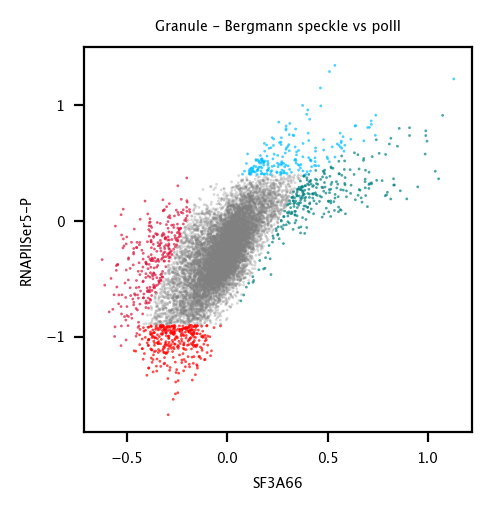

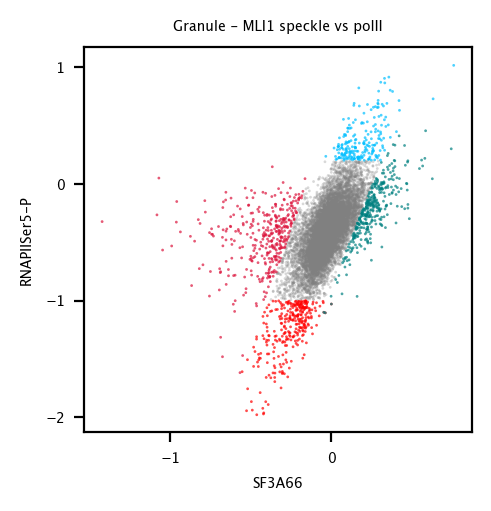

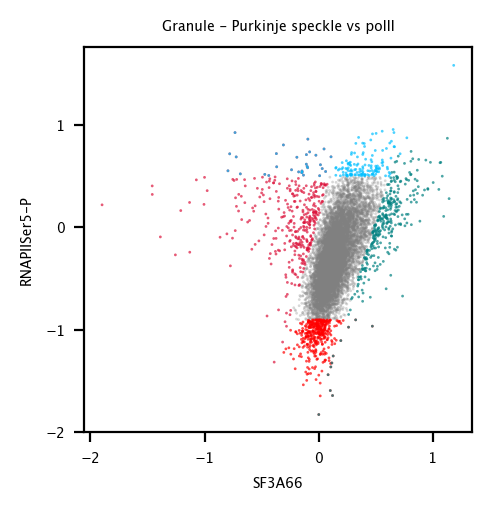

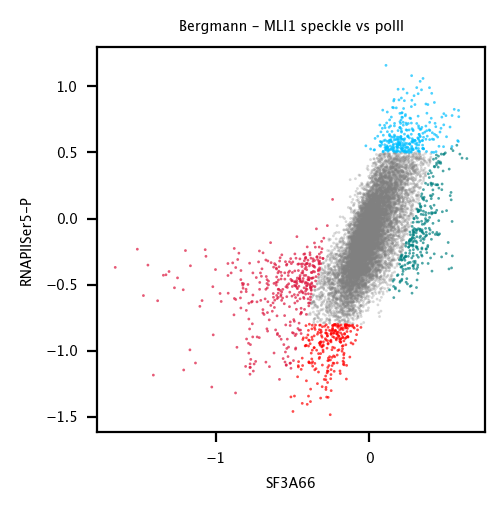

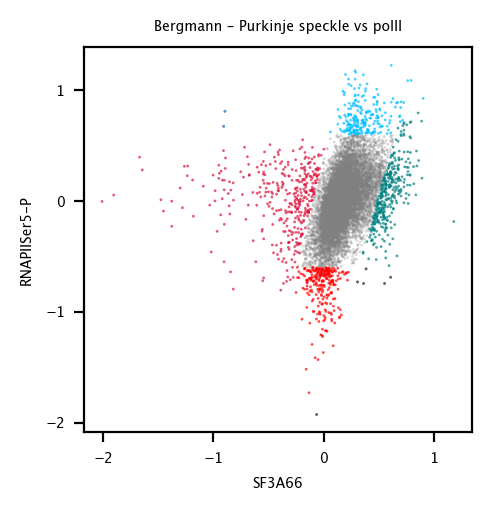

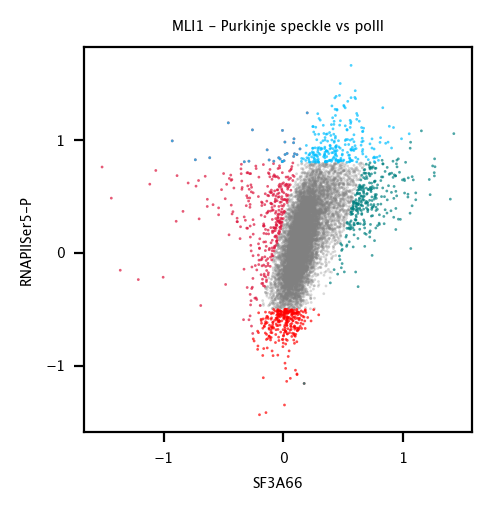

In [103]:
for idx1 in range(4):
    for idx2 in range(idx1 + 1, 4):
        ld1, ld2  = leidens[idx1], leidens[idx2]
        cell_type1, cell_type2 = cell_types[idx1], cell_types[idx2]

        meta = pd.read_csv(str(data_root / "annotation" / "LC1-100k-09022022-mm10-200kb-meta.csv"))
        df1 = pd.read_csv(str(data_root / experiment / "IF_ensemble" / f"IF_markers_median_200kb_binned_cerebellum_leiden_{ld1}.csv"))
        df2 = pd.read_csv(str(data_root / experiment / "IF_ensemble" / f"IF_markers_median_200kb_binned_cerebellum_leiden_{ld2}.csv"))

        # make sure meta is in the same order as IF dataframe
        meta = meta.merge(df1["200kb name"])

        m1 = "SF3A66"
        m2 = "RNAPIISer5-P"

        x1 = df1[m1].values
        x2 = df2[m1].values

        y1 = df1[m2].values
        y2 = df2[m2].values

        de_x = x1 - x2
        de_y = y1 - y2

        xx = de_x
        yy = de_y
        X = np.vstack([xx, yy]).T
        spk_lb, spk_intercept = find_interscept(X, "above", c = -4, slope =4, percentile = 0.03, eps = 0.1)
        pol_lb, pol_intercept = find_interscept(X, "below", c = 4, slope =0, percentile = 0.03, eps = 0.1)

        # overlap bins:
        overlap_idx = np.where((spk_lb == 1) & (pol_lb == 1))[0]
        for i in overlap_idx:
            if xx[i] >= yy[i]:
                pol_lb[i] = 0
            else:
                if xx[i] < -0.5:
                    pol_lb[i] = 0
                else:
                    spk_lb[i] = 0

        # save peak define
        meta[f"{cell_type2}_pol_ass"] = pol_lb
        meta[f"{cell_type2}_spk_ass"] = spk_lb
        df1[f"{cell_type2}_pol_ass"] = pol_lb
        df1[f"{cell_type2}_spk_ass"] = spk_lb
        df2[f"{cell_type2}_pol_ass"] = pol_lb
        df2[f"{cell_type2}_spk_ass"] = spk_lb



        spk_lb, spk_intercept = find_interscept(X, "below", c = 4, slope =3.5, percentile = 0.03, eps = 0.1)
        pol_lb, pol_intercept = find_interscept(X, "above", c = -4, slope =0, percentile = 0.03, eps = 0.1)

        # overlap bins:
        overlap_idx = np.where((spk_lb == 1) & (pol_lb == 1))[0]
        for i in overlap_idx:
            if xx[i] >= yy[i]:
                pol_lb[i] = 0
            else:
                if xx[i] < -0.5:
                    pol_lb[i] = 0
                else:
                    spk_lb[i] = 0

        # save peak define
        meta[f"{cell_type1}_pol_ass"] = pol_lb
        meta[f"{cell_type1}_spk_ass"] = spk_lb
        df1[f"{cell_type1}_pol_ass"] = pol_lb
        df1[f"{cell_type1}_spk_ass"] = spk_lb
        df2[f"{cell_type1}_pol_ass"] = pol_lb
        df2[f"{cell_type1}_spk_ass"] = spk_lb

        meta.to_csv(str(data_root / 
                        experiment / 
                        "Fig3" / "differential_association_spk_vs_polII" / 
                        f"{cell_type1}-{cell_type2}_spk_vs_polII_differential_association_200kb.csv"), index = False )
        
        plt.figure(figsize = (2.5, 2.5))

        purk_pol_idx = (meta[f"{cell_type2}_pol_ass"] == 1).values
        purk_spk_idx = (meta[f"{cell_type2}_spk_ass"] == 1).values

        berg_pol_idx = (meta[f"{cell_type1}_pol_ass"] == 1).values
        berg_spk_idx = (meta[f"{cell_type1}_spk_ass"] == 1).values

        other_idx = ~(purk_pol_idx + purk_spk_idx + berg_pol_idx + berg_spk_idx)
        plt.scatter(xx[other_idx], yy[other_idx], color = "gray", s = 1, alpha = 0.3, linestyle='None', edgecolors = "None", label = "others")
        plt.scatter(xx[purk_pol_idx], yy[purk_pol_idx], color = "red", s = 1, alpha = 0.7, linestyle='None', edgecolors = "None")
        plt.scatter(xx[purk_spk_idx], yy[purk_spk_idx], color = "crimson", s = 1, alpha = 0.7, linestyle='None', edgecolors = "None")
        plt.scatter(xx[berg_spk_idx], yy[berg_spk_idx], color = "teal", s = 1, alpha = 0.7, linestyle='None', edgecolors = "None")
        plt.scatter(xx[berg_pol_idx], yy[berg_pol_idx], color = "deepskyblue", s = 1, alpha = 0.7, linestyle='None', edgecolors = "None")

        plt.xticks(fontsize=5)
        plt.xlabel("SF3A66", fontsize = 5)
        plt.yticks(fontsize=5)
        plt.ylabel("RNAPIISer5-P", fontsize = 5)
        plt.title(f"{cell_type1} - {cell_type2} speckle vs polII", fontsize = 5)
        plt.show()
        rna_df = pd.read_csv(str(data_root / experiment / "differential_expression" / "RNA_DE" / f"{cell_type1}_{cell_type2}_DE_200kb_FoldChange.csv" ))
        meta.merge(rna_df[["200kb name", f"log2FC_{cell_type1[0]}2{cell_type2[0]}"]]).to_csv(str(data_root / experiment / "Fig3" /  f"{cell_type1}-{cell_type2}_spk_polII_differential_association_200kb_rna_DE.csv"), index  = None)
